In [1]:
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

# qiskit modules
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.providers.aer import noise

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account()  # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
simulator_noise = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmqx2')  #ibmq_burlington ibmq_16_melbourne ibmq_ourense

# needed for noisy simulator
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

/home/nico/Environments/dev_qiskit/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


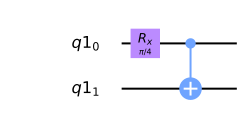

In [3]:
# creating a random initial state for 0th qbit
R = []
for i in range(3):
    R.append(10*random.random())

qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
# qc_expected.rx(np.pi/5*R[0],0)
# qc_expected.ry(np.pi/5*R[1],0)
# qc_expected.rz(np.pi/5*R[2],0)
qc_expected.rx(np.pi/4,0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [9.23879533e-01+0.j         0.00000000e+00+0.j
 0.00000000e+00+0.j         2.34326020e-17-0.38268343j]


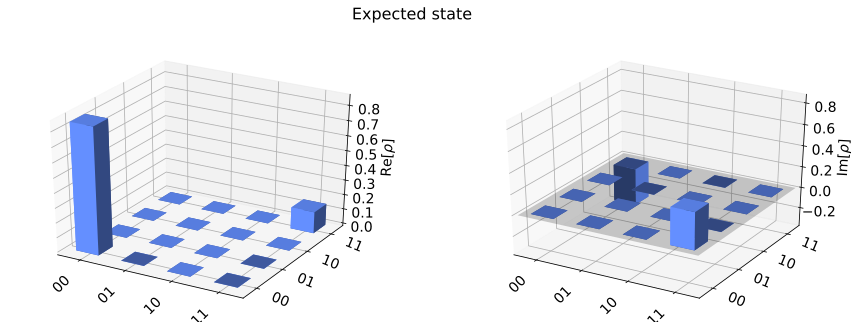

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

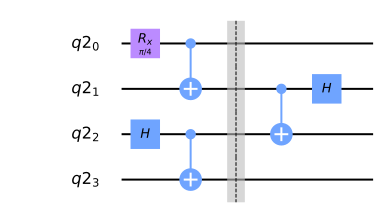

In [5]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr)
# qc.rx(np.pi/5*R[0],0)
# qc.ry(np.pi/5*R[1],0)
# qc.rz(np.pi/5*R[2],0)
qc.rx(np.pi/4,0)
qc.h(2)
qc.cx(0,1)
qc.cx(2,3)
qc.barrier()
qc.cx(1,2)
qc.h(1)
qc.draw(output='mpl')

In [6]:
# qc2 = QuantumCircuit(qr)
# qc3 = QuantumCircuit(qr)
# qc4 = QuantumCircuit(qr)
# qcs = [qct,qc2,qc3,qc4]
# for qc in range(3):
#     q2 = QuantumCircuit(qr)
#     if qc == 0 or qc == 2:
#         q2.z(3)
#     if qc == 1 or qc == 2:
#         q2.x(3)
#     p= qc1 +q2
#     q= state_tomography_circuits(p,[qr])
#     qcf=[q[24],q[25],q[26],q[51],q[52],q[53],q[78],q[79],q[80]]
#     qcs[qc+1] =qcf
# qcs[2][8].draw(output='mpl')

In [7]:
# #readout calibration measurements
# cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
# cal_job = qiskit.execute(cal_circuits, backend = device, shots = 1024, optimization_level = 0)
# job_monitor(cal_job)
# calres = cal_job.result()
# meas_fitter = CompleteMeasFitter(calres, state_labels)
# meas_fitter.plot_calibration()

In [8]:
# defining tomography circuits
qcz = state_tomography_circuits(qc,qr)
# the nine circuits are in the order [XZZX, XZZY, XZZZ, YZZX, YZZY, YZZZ, ZZZX, ZZZY, ZZZZ]
qst_circuit = [qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]

# drawing one of the tomography circuits to check
# qst_circuit[0].draw(output='mpl')

In [9]:
backends = [simulator, simulator_noise, device]
# measureqbit= [qreg[0],qreg[3]]
# result =[0,0,0,0]
# x=0
bits = [ '0000', '1000', '0001', '1001', '0010', '1010', '0011', '1011','0100', '1100', '0101', '1101', '0110', '1110', '0111', '1111']
paulis = [('X','Z','Z','X'),('X','Z','Z','Y'),('X','Z','Z','Z'),('Y','Z','Z','X'),('Y','Z','Z','Y'),('Y','Z','Z','Z'),('Z','Z','Z','X'),('Z','Z','Z','Y'),('Z','Z','Z','Z')]
basis = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']

# paulis = [('X','Z','Z','X'),('Y','Z','Z','X'),('Z','Z','Z','X'),('X','Z','Z','Y'),('Y','Z','Z','Y'),('Z','Z','Z','Y'),('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]
# basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']

for num, backend in enumerate(backends):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '01': 0, '10': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, backend, shots=8192) # for ideal simulator
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim = qiskit.execute(qst_circuit, backend, shots=8192,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    
    # 4 possible outcomes of teleport protocol, where the final state is either
    # psi, IX @ psi, IZ @ psi, IZ @ IX @ psi. We store all 4 seperately, to then transform
    # the resulting density matrices appropriately before finding fidelity
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}

    if num == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state_df
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

The full state for the simulator is                                              XX  \
0  {'00': 530, '01': 499, '10': 512, '11': 500}   
1  {'00': 515, '01': 483, '10': 503, '11': 521}   
2  {'00': 527, '01': 526, '10': 540, '11': 507}   
3  {'00': 539, '01': 503, '10': 474, '11': 513}   

                                             XY  \
0  {'00': 165, '01': 862, '10': 855, '11': 181}   
1  {'00': 877, '01': 159, '10': 164, '11': 839}   
2  {'00': 848, '01': 153, '10': 159, '11': 948}   
3  {'00': 143, '01': 876, '10': 828, '11': 135}   

                                             XZ  \
0  {'00': 855, '01': 881, '10': 145, '11': 144}   
1  {'00': 908, '01': 894, '10': 154, '11': 148}   
2  {'00': 134, '01': 148, '10': 854, '11': 903}   
3  {'00': 140, '01': 161, '10': 880, '11': 843}   

                                             YX  \
0  {'00': 156, '01': 887, '10': 864, '11': 141}   
1  {'00': 858, '01': 145, '10': 147, '11': 869}   
2  {'00': 142, '01': 857, '10': 867, '11': 

In [10]:
# first we define the basis for 2 qubits
I_matrix = np.matrix('1, 0; 0, 1')
X_matrix = np.matrix('0, 1; 1, 0')
Y_matrix = np.matrix('0, 0-1j; 0+1j, 0')
Z_matrix = np.matrix('1, 0; 0, -1')

# 16 total basis matrices
II_matrix = np.kron(I_matrix,I_matrix)

IX_matrix = np.kron(I_matrix,X_matrix)
IY_matrix = np.kron(I_matrix,Y_matrix)
IZ_matrix = np.kron(I_matrix,Z_matrix)

XI_matrix = np.kron(X_matrix,I_matrix)
YI_matrix = np.kron(Y_matrix,I_matrix)
ZI_matrix = np.kron(Z_matrix,I_matrix)

XX_matrix = np.kron(X_matrix,X_matrix)
XY_matrix = np.kron(X_matrix,Y_matrix)
XZ_matrix = np.kron(X_matrix,Z_matrix)

YX_matrix = np.kron(Y_matrix,X_matrix)
YY_matrix = np.kron(Y_matrix,Y_matrix)
YZ_matrix = np.kron(Y_matrix,Z_matrix)

ZX_matrix = np.kron(Z_matrix,X_matrix)
ZY_matrix = np.kron(Z_matrix,Y_matrix)
ZZ_matrix = np.kron(Z_matrix,Z_matrix)

In [11]:
# fidelity processing for sim and dev
r_sim = np.zeros((4,9))
r_sim_noise = np.zeros((4,9))
r_dev = np.zeros((4,9))

for i in range(4):
    for j in range(9):
        r_sim[i,j] = (state_sim[basis[j]][i]['00']*1 + state_sim[basis[j]][i]['11']*1 + state_sim[basis[j]][i]['01']*(-1) + state_sim[basis[j]][i]['10']*(-1))/(state_sim[basis[j]][i]['00'] + state_sim[basis[j]][i]['11'] + state_sim[basis[j]][i]['01'] + state_sim[basis[j]][i]['10'])
        r_sim_noise[i,j] = (state_sim_noise[basis[j]][i]['00']*1 + state_sim_noise[basis[j]][i]['11']*1 + state_sim_noise[basis[j]][i]['01']*(-1) + state_sim_noise[basis[j]][i]['10']*(-1))/(state_sim_noise[basis[j]][i]['00'] + state_sim_noise[basis[j]][i]['11'] + state_sim_noise[basis[j]][i]['01'] + state_sim_noise[basis[j]][i]['10'])
        r_dev[i,j] = (state_dev[basis[j]][i]['00']*1 + state_dev[basis[j]][i]['11']*1 + state_dev[basis[j]][i]['01']*(-1) + state_dev[basis[j]][i]['10']*(-1))/(state_dev[basis[j]][i]['00'] + state_dev[basis[j]][i]['11'] + state_dev[basis[j]][i]['01'] + state_dev[basis[j]][i]['10'])

In [12]:
r_IPaul_sim = np.zeros((4,9))
r_PaulI_sim = np.zeros((4,9))
r_IPaul_sim_noise = np.zeros((4,9))
r_PaulI_sim_noise = np.zeros((4,9))
r_IPaul_dev = np.zeros((4,9))
r_PaulI_dev = np.zeros((4,9))

# finding the XI, YI, ZI coefficients (finding each coef. 3x to check similarity)
# creates an array of [r_xi, r_yi, r_zi, r_xi, r_yi, r_zi, r_xi, r_yi, r_zi]
for i in range(4):
    for jj in range(9):
        r_PaulI_sim[i,jj] = (state_sim[basis[jj]][i]['00']*1 + state_sim[basis[jj]][i]['11']*(-1) + state_sim[basis[jj]][i]['01']*(1) + state_sim[basis[jj]][i]['10']*(-1))/(state_sim[basis[jj]][i]['00'] + state_sim[basis[jj]][i]['11'] + state_sim[basis[jj]][i]['01'] + state_sim[basis[jj]][i]['10'])
        r_PaulI_sim_noise[i,jj] = (state_sim_noise[basis[jj]][i]['00']*1 + state_sim_noise[basis[jj]][i]['11']*(-1) + state_sim_noise[basis[jj]][i]['01']*(1) + state_sim_noise[basis[jj]][i]['10']*(-1))/(state_sim_noise[basis[jj]][i]['00'] + state_sim_noise[basis[jj]][i]['11'] + state_sim_noise[basis[jj]][i]['01'] + state_sim_noise[basis[jj]][i]['10'])
        r_PaulI_dev[i,jj] = (state_dev[basis[jj]][i]['00']*1 + state_dev[basis[jj]][i]['11']*(-1) + state_dev[basis[jj]][i]['01']*(1) + state_dev[basis[jj]][i]['10']*(-1))/(state_dev[basis[jj]][i]['00'] + state_dev[basis[jj]][i]['11'] + state_dev[basis[jj]][i]['01'] + state_dev[basis[jj]][i]['10'])
        
# finding the IX, IY, IZ coeffs (again 3x each)
# creates an array of [r_ix, r_ix, r_ix, r_iy, r_iy, r_iy, r_iz, r_iz, r_iz]
basis2 = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
for i in range(4):
    for jj in range(9):
        r_IPaul_sim[i,jj] = (state_sim[basis2[jj]][i]['00']*1 + state_sim[basis2[jj]][i]['11']*(-1) + state_sim[basis2[jj]][i]['01']*(-1) + state_sim[basis2[jj]][i]['10']*(1))/(state_sim[basis2[jj]][i]['00'] + state_sim[basis2[jj]][i]['11'] + state_sim[basis2[jj]][i]['01'] + state_sim[basis2[jj]][i]['10'])
        r_IPaul_sim_noise[i,jj] = (state_sim_noise[basis2[jj]][i]['00']*1 + state_sim_noise[basis2[jj]][i]['11']*(-1) + state_sim_noise[basis2[jj]][i]['01']*(-1) + state_sim_noise[basis2[jj]][i]['10']*(1))/(state_sim_noise[basis2[jj]][i]['00'] + state_sim_noise[basis2[jj]][i]['11'] + state_sim_noise[basis2[jj]][i]['01'] + state_sim_noise[basis2[jj]][i]['10'])
        r_IPaul_dev[i,jj] = (state_dev[basis2[jj]][i]['00']*1 + state_dev[basis2[jj]][i]['11']*(-1) + state_dev[basis2[jj]][i]['01']*(-1) + state_dev[basis2[jj]][i]['10']*(1))/(state_dev[basis2[jj]][i]['00'] + state_dev[basis2[jj]][i]['11'] + state_dev[basis2[jj]][i]['01'] + state_dev[basis2[jj]][i]['10'])


In [ ]:
for i in range(4):
    r_PaulI_sim[i,0] = (r_PaulI_sim[i,0]+r_PaulI_sim[i,3]+r_PaulI_sim[i,6]) / 3
    r_PaulI_sim[i,1] = (r_PaulI_sim[i,1]+r_PaulI_sim[i,4]+r_PaulI_sim[i,7]) / 3
    r_PaulI_sim[i,2] = (r_PaulI_sim[i,2]+r_PaulI_sim[i,5]+r_PaulI_sim[i,8]) / 3
    
    r_PaulI_sim_noise[i,0] = (r_PaulI_sim_noise[i,0]+r_PaulI_sim_noise[i,3]+r_PaulI_sim_noise[i,6]) / 3
    r_PaulI_sim_noise[i,1] = (r_PaulI_sim_noise[i,1]+r_PaulI_sim_noise[i,4]+r_PaulI_sim_noise[i,7]) / 3
    r_PaulI_sim_noise[i,2] = (r_PaulI_sim_noise[i,2]+r_PaulI_sim_noise[i,5]+r_PaulI_sim_noise[i,8]) / 3
    
    r_PaulI_dev[i,0] = (r_PaulI_dev[i,0]+r_PaulI_dev[i,3]+r_PaulI_dev[i,6]) / 3
    r_PaulI_dev[i,1] = (r_PaulI_dev[i,1]+r_PaulI_dev[i,4]+r_PaulI_dev[i,7]) / 3
    r_PaulI_dev[i,2] = (r_PaulI_dev[i,2]+r_PaulI_dev[i,5]+r_PaulI_dev[i,8]) / 3

In [13]:
# r_cor = np.zeros((4,9))
# # haven't implemented readout calibration for 2 qbits yet, so r_cor = r_dev
# r_cor = r_dev
# # r_cor[:,:] = (r_dev[:,:] - beta0) / beta1

In [14]:
rho_sim = [0,0,0,0]
rho_sim_noise = [0,0,0,0]
rho_dev = [0,0,0,0]

for i in range(4):
    rho_sim[i] = (1/4)*(II_matrix + 
                        r_IPaul_sim[i,0]*IX_matrix + r_IPaul_sim[i,3]*IY_matrix + r_IPaul_sim[i,6]*IZ_matrix + 
                        r_PaulI_sim[i,0]*XI_matrix + r_PaulI_sim[i,1]*YI_matrix + r_PaulI_sim[i,2]*ZI_matrix + 
                        r_sim[i,0]*XX_matrix + r_sim[i,1]*XY_matrix + r_sim[i,2]*XZ_matrix + 
                        r_sim[i,3]*YX_matrix + r_sim[i,4]*YY_matrix + r_sim[i,5]*YZ_matrix + 
                        r_sim[i,6]*ZX_matrix + r_sim[i,7]*ZY_matrix + r_sim[i,8]*ZZ_matrix)
    rho_sim_noise[i] = (1/4)*(II_matrix + 
                        r_IPaul_sim_noise[i,0]*IX_matrix + r_IPaul_sim_noise[i,3]*IY_matrix + r_IPaul_sim_noise[i,6]*IZ_matrix + 
                        r_PaulI_sim_noise[i,0]*XI_matrix + r_PaulI_sim_noise[i,1]*YI_matrix + r_PaulI_sim_noise[i,2]*ZI_matrix + 
                        r_sim_noise[i,0]*XX_matrix + r_sim_noise[i,1]*XY_matrix + r_sim_noise[i,2]*XZ_matrix + 
                        r_sim_noise[i,3]*YX_matrix + r_sim_noise[i,4]*YY_matrix + r_sim_noise[i,5]*YZ_matrix + 
                        r_sim_noise[i,6]*ZX_matrix + r_sim_noise[i,7]*ZY_matrix + r_sim_noise[i,8]*ZZ_matrix)
    rho_dev[i] = (1/4)*(II_matrix + 
                        r_IPaul_dev[i,0]*IX_matrix + r_IPaul_dev[i,3]*IY_matrix + r_IPaul_dev[i,6]*IZ_matrix + 
                        r_PaulI_dev[i,0]*XI_matrix + r_PaulI_dev[i,1]*YI_matrix + r_PaulI_dev[i,2]*ZI_matrix + 
                        r_dev[i,0]*XX_matrix + r_dev[i,1]*XY_matrix + r_dev[i,2]*XZ_matrix + 
                        r_dev[i,3]*YX_matrix + r_dev[i,4]*YY_matrix + r_dev[i,5]*YZ_matrix + 
                        r_dev[i,6]*ZX_matrix + r_dev[i,7]*ZY_matrix + r_dev[i,8]*ZZ_matrix)


In [15]:
rho = pd.DataFrame(data=[rho_sim, rho_sim_noise, rho_dev])
for ind in range(3):
    rho.loc[ind][1] = IZ_matrix @ rho.loc[ind][1] @ IZ_matrix
    rho.loc[ind][2] = IX_matrix @ rho.loc[ind][2] @ IX_matrix
    rho.loc[ind][3] = IZ_matrix @ IX_matrix @ rho.loc[ind][3] @ IX_matrix @ IZ_matrix

In [16]:
np.outer(psi_expected,psi_expected)

array([[ 8.53553391e-01+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  2.16489014e-17-3.53553391e-01j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 2.16489014e-17-3.53553391e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -1.46446609e-01-1.79345371e-17j]])

In [17]:
# rho[0][0]

In [18]:
# rho[1][0]

In [19]:
# rho[2][0]

In [20]:
# rho[3][0]

In [21]:
Fidelity = np.zeros((3,4))
for i in range(3):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[j][i], validate=False)
print(Fidelity)

F = np.mean(Fidelity,axis=1)
print('Simulator Fidelity:', F[0])
print('Noisy Simulator Fidelity:', F[1])
print('Device Fidelity:', F[2])
# print('Corrected Device Fidelity:', F[3])

[[0.86712088 0.87412302 0.62404148 0.62529246]
 [0.76443508 0.75160792 0.56904939 0.57621446]
 [0.69217961 0.53911128 0.50281595 0.51396447]]
Simulator Fidelity: 0.7476444592418535
Noisy Simulator Fidelity: 0.6653267112524435
Device Fidelity: 0.5620178269300692


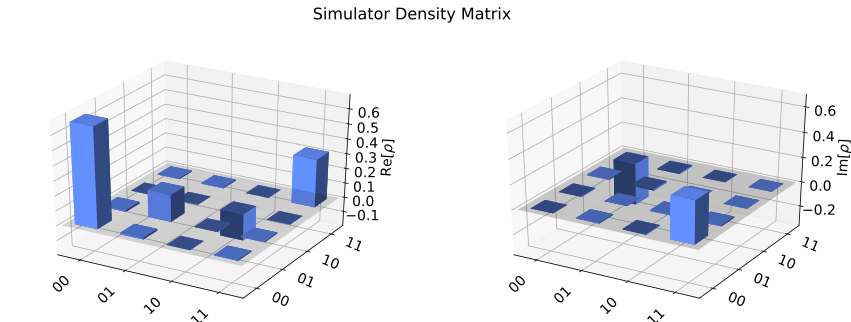

In [22]:
plot_state_city(rho[0][0], title='Simulator Density Matrix')

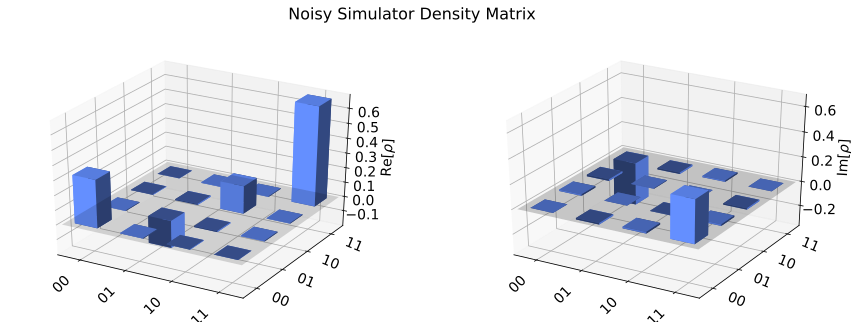

In [23]:
plot_state_city(rho[2][0], title='Noisy Simulator Density Matrix')

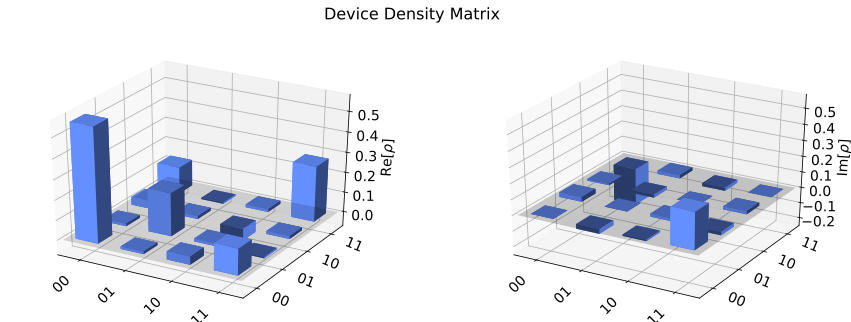

In [24]:
plot_state_city(rho[0][2], title='Device Density Matrix')

In [25]:
# checking validity of the density matrices
rho_sim = DensityMatrix(rho[0][1])
rho_dev = DensityMatrix(rho[0][2])
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? False
Is the device density matrix valid? False


In [26]:
import qiskit.tools.jupyter
%qiskit_version_table